# Example notebook for pairwise registration using GreedyFHist



### Step 1: Loading image data

GreedyFHist has some utility functions for load image data, but ultimately the only requirement is that image data can be converted to a `numpy.ndarray`.

In [1]:
import os
from os.path import exists, join
import matplotlib.pyplot as plt

import numpy as np

from greedyfhist.data_types import Image, Pointset
from greedyfhist.registration import GreedyFHist, RegistrationResult
from greedyfhist.options import RegistrationOptions
from greedyfhist.utils.io import read_image, write_to_ometiffile

In [2]:
OUTPUT_DIR = 'out'
if not exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

In [3]:
path_to_moving_image = '../pairwise_examples/images/moving_image.ome.tif'
path_to_fixed_image = '../pairwise_examples/images/fixed_image.ome.tif'

moving_image = Image.load_from_path(path_to_moving_image)
fixed_image = Image.load_from_path(path_to_fixed_image)

In [4]:
moving_img = moving_image.data
fixed_img = fixed_image.data

Text(0.5, 1.0, 'Fixed Image')

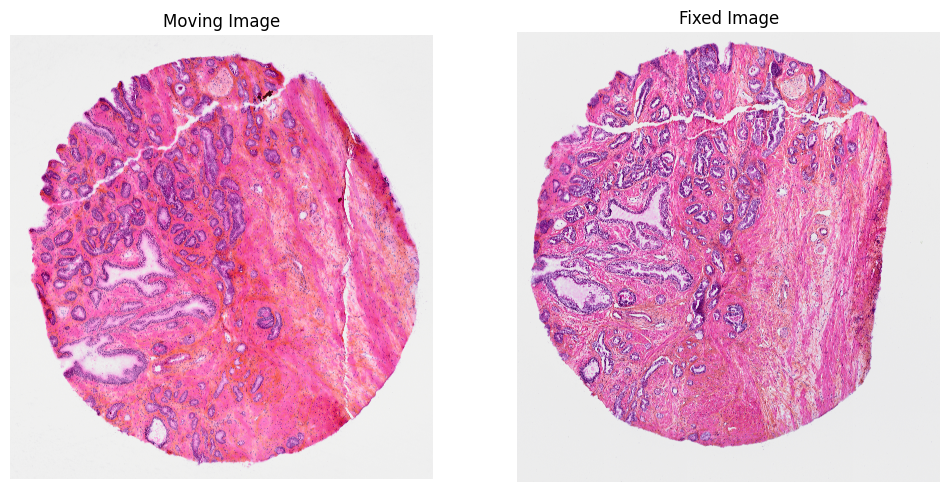

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(moving_image.data)
axs[0].set_title('Moving Image')
axs[1].imshow(fixed_image.data)
axs[1].set_title('Fixed Image')

### Step 2: Setting registration options and performing registration.

In [6]:
# Set this option only to True, if greedy is used as an external docker image.
# If MIIT, GreedyFHist and Greedy are used from with the same docker container or if
# from no docker container at all, set this to False.

# Normally, this option can stay as False.
use_greedyfhist_from_external_docker_container = False

if use_greedyfhist_from_external_docker_container:
    path_to_greedy = 'mwess89/greedy:1.3.0-alpha'
    use_docker_container = True
else:
    path_to_greedy = 'greedy'
    use_docker_container = False

registerer = GreedyFHist(path_to_greedy=path_to_greedy, use_docker_container=use_docker_container)

In [7]:

# Default options do not need to be parsed
options = RegistrationOptions()
options.affine_registration_options.n_threads = 8
options.nonrigid_registration_options.n_threads = 8
# For large images we recommend to use downscaling.
# options.pre_sampling_factor = 0.25

registration_result = registerer.register(moving_img=moving_image.data,
                                          fixed_img=fixed_image.data,
                                          options=options
                                          )

A registration result consists of 2 transformations: A forward transformation from moving to fixed image space and a backward transformation from fixed to moving image space. Internally transformations are executed using SimpleITK. Forward transformations are used to transform image data, backward transformations are used for pointset valued data.

In [8]:
warped_moving_image = registerer.transform_image(moving_image.data, registration_result.registration.forward_transform)

Text(0.5, 1.0, 'Transformed Image')

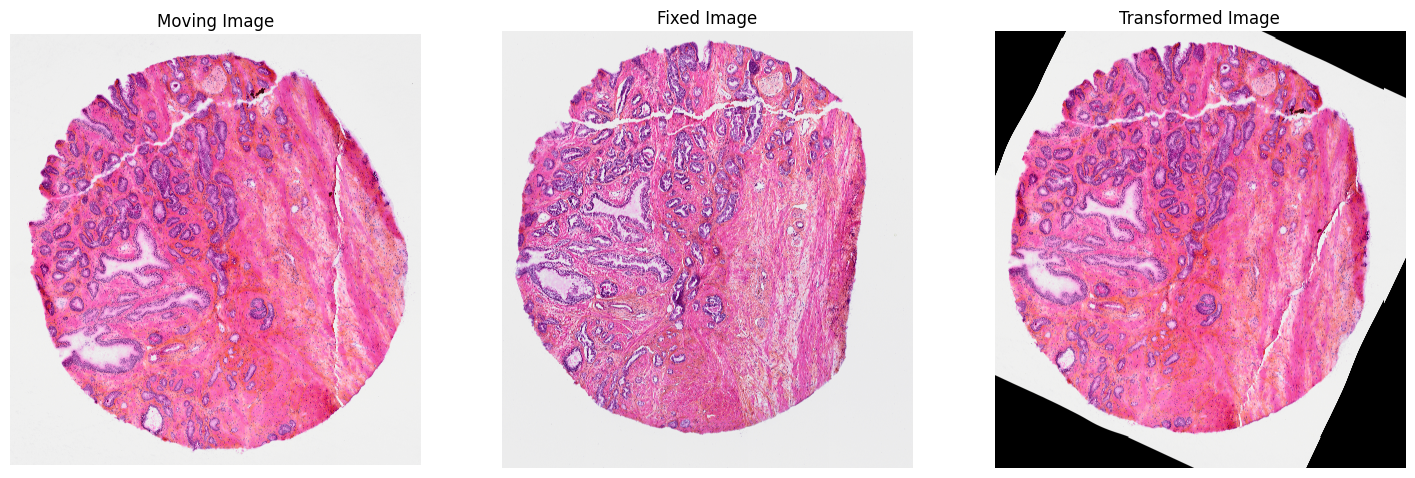

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(moving_image.data)
axs[0].set_title('Moving Image')
axs[1].imshow(fixed_image.data)
axs[1].set_title('Fixed Image')
axs[2].imshow(warped_moving_image)
axs[2].set_title('Transformed Image')

### 2.1 Fine-tuning the registration by supplying a custom segmentation mask.

We can also define custom registration masks to fine-tune the registration

In [11]:
custom_mask = np.zeros(warped_moving_image.shape[:2], dtype=np.uint8)
custom_mask[2000:7000, 3000:8000] = 1

masked_fixed_image = fixed_image.data * np.expand_dims(custom_mask, -1)
masked_warped_image = warped_moving_image * np.expand_dims(custom_mask, -1)


In [12]:
options = RegistrationOptions()
options.do_affine_registration = False
options.nonrigid_registration_options.n_threads = 8

fine_tuning_reg_result = registerer.register(
    warped_moving_image,
    fixed_image.data,
    custom_mask,
    custom_mask,
    options
)

fine_tuned_warped_image = registerer.transform_image(warped_moving_image, fine_tuning_reg_result)
masked_fine_tuned_warped_image = fine_tuned_warped_image * np.expand_dims(custom_mask, -1)

We can see how the registered image with and without mask looks like.

Text(0.5, 1.0, 'Fine tuned warped image (no mask)')

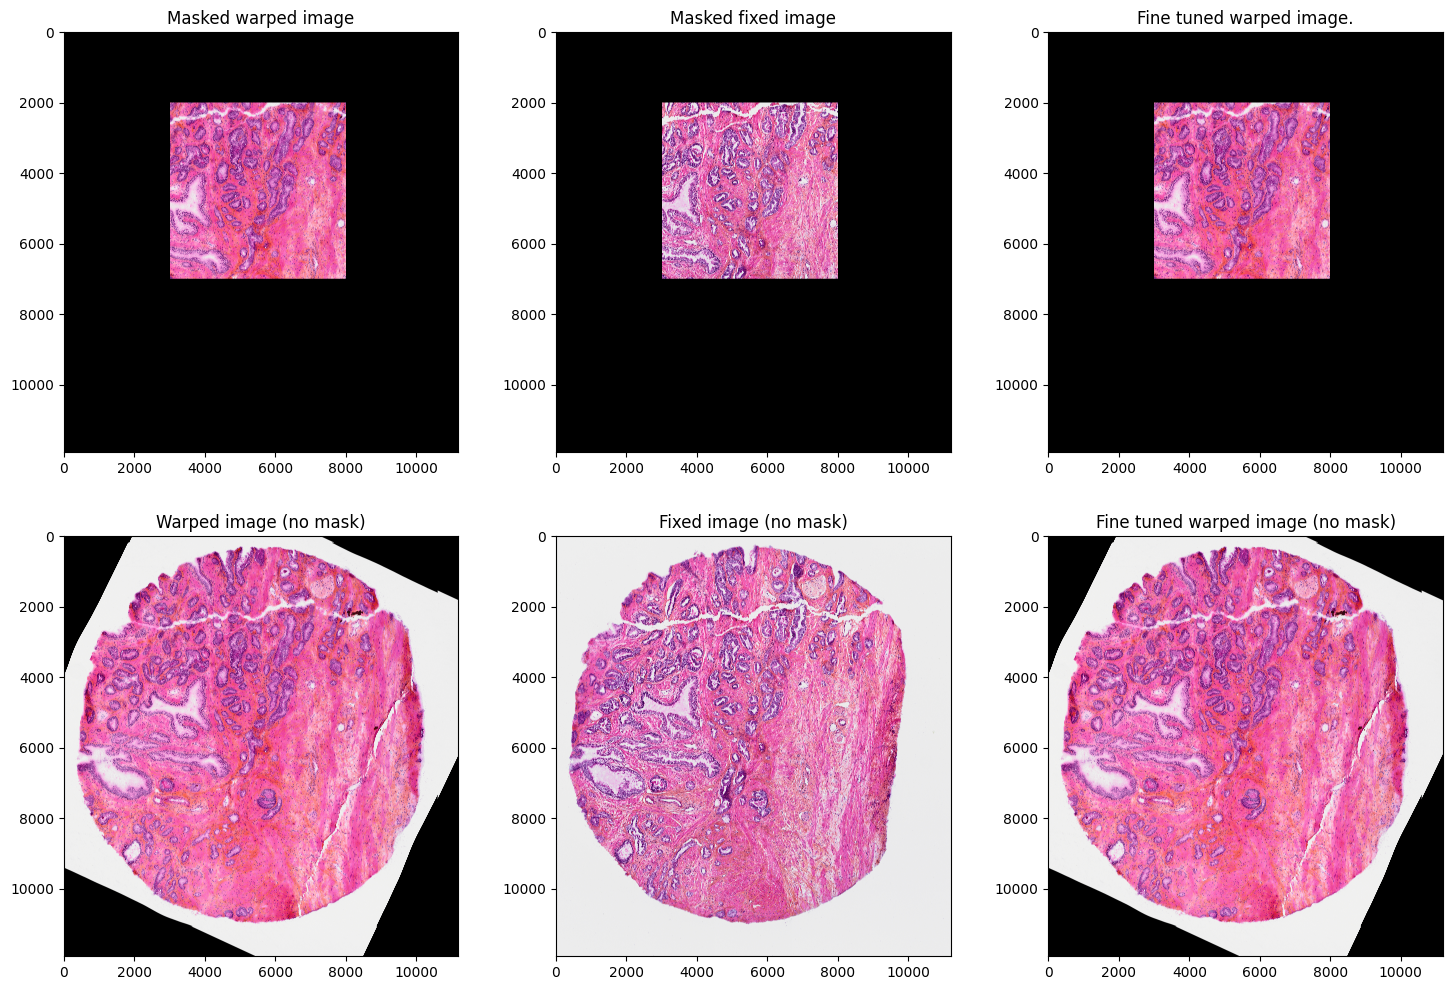

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs[0, 0].imshow(masked_warped_image)
axs[0, 0].set_title('Masked warped image')
axs[0, 1].imshow(masked_fixed_image)
axs[0, 1].set_title('Masked fixed image')
axs[0, 2].imshow(masked_fine_tuned_warped_image)
axs[0, 2].set_title('Fine tuned warped image.')
axs[1, 0].imshow(warped_moving_image)
axs[1, 0].set_title('Warped image (no mask)')
axs[1, 1].imshow(fixed_image.data)
axs[1, 1].set_title('Fixed image (no mask)')
axs[1, 2].imshow(fine_tuned_warped_image)
axs[1, 2].set_title('Fine tuned warped image (no mask)')

We can also compose registrations for more compactness.

In [14]:
from greedyfhist.registration.greedy_f_hist import compose_registration_results

composed_transform = compose_registration_results([registration_result, fine_tuning_reg_result])

### Step 3: Saving and loading transformation data

Transformations can be stored and loaded at a later point.

In [15]:
registration_result.to_directory(join(OUTPUT_DIR, 'saved_transform'))
loaded_reg_result = RegistrationResult.load(join(OUTPUT_DIR, 'saved_transform'))

In [16]:
warped_image2 = registerer.transform_image(moving_image.data, loaded_reg_result.registration.forward_transform, 'LINEAR')

In [17]:
ps  = Pointset.load_from_path('../pairwise_examples/annotations/moving_pointset.csv')
warped_ps = registerer.transform_pointset(ps.to_numpy(), loaded_reg_result.registration.backward_transform)

Text(0.5, 1.0, 'Warped image from loaded registration.')

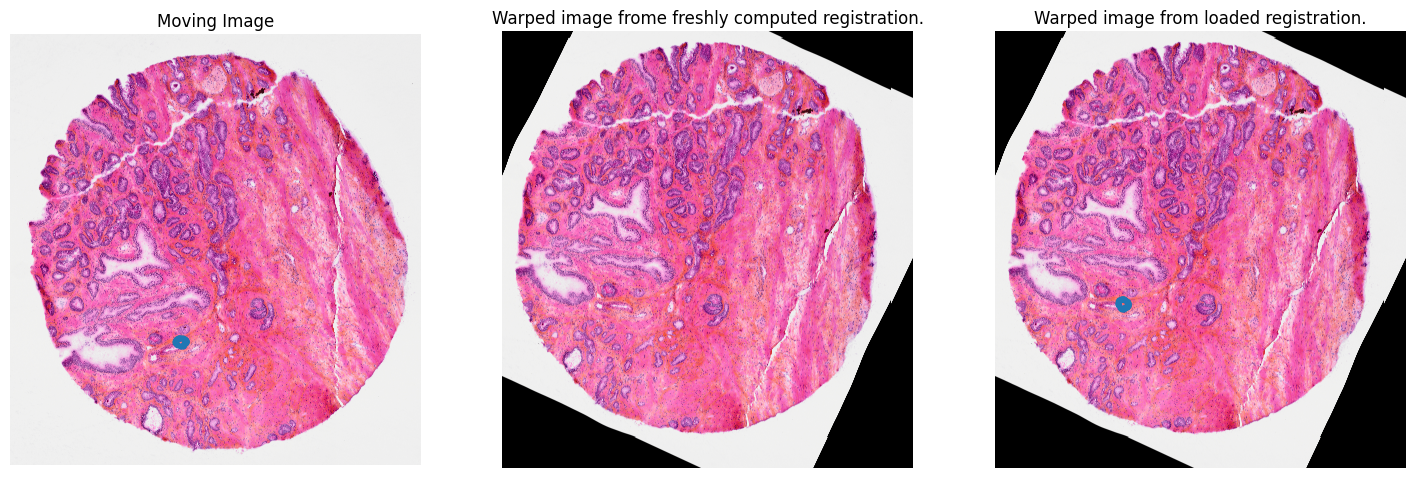

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(18 ,6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(moving_image.data)
ps_np = ps.to_numpy()
axs[0].plot(ps_np[:, 0], ps_np[:, 1], '.')
axs[0].set_title('Moving Image')
axs[1].imshow(warped_moving_image)
axs[1].set_title('Warped image frome freshly computed registration.')
axs[2].imshow(warped_image2)
axs[2].plot(warped_ps[:, 0], warped_ps[:, 1], '.')
axs[2].set_title('Warped image from loaded registration.')

### Alternative: Registration using filepaths

Alternatively, GreedyFHist has a helper function that allows us to register images by supplying filepaths. The registered image is stored as an `ome.tif`. 

In [19]:
path_to_moving_image = '../pairwise_examples/images/moving_image.ome.tif'
path_to_fixed_image = '../pairwise_examples/images/fixed_image.ome.tif'
path_to_warped_image = join(OUTPUT_DIR, 'warped_image.ome.tif')
path_to_saved_transform = join(OUTPUT_DIR, 'saved_transform2')

registerer = GreedyFHist(path_to_greedy=path_to_greedy)

registration_result, warped_image = registerer.register_from_filepaths(path_to_moving_image, 
                                                                       path_to_fixed_image, 
                                                                       path_to_warped_image,
                                                                       transform_path=path_to_saved_transform)

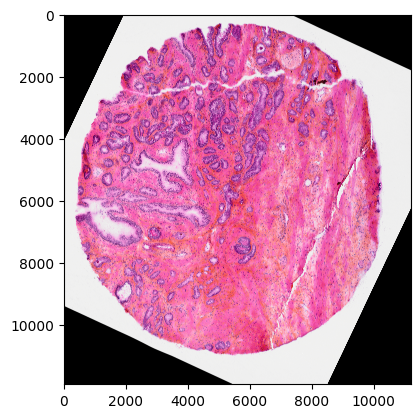

In [20]:
warped_image_loaded = read_image(path_to_warped_image)[0].data
plt.imshow(warped_image_loaded)

In [21]:
options = RegistrationOptions()
options.affine_registration_options.n_threads = 8
options.nonrigid_registration_options.n_threads = 8

registration_result = registerer.register(moving_img=moving_image.data,
                                          fixed_img=fixed_image.data,
                                          options=options
                                          )

warped_image = registerer.transform_image(moving_image.data, registration_result)

### Tiling Registration

In most cases, the non-rigid registration will be enough to find an accurate registration between fixed and moving image. However, in some cases, downscaling large images might remove valuable image features. Also `greedy` itself has an upper limit for how high the resolution of fixed and moving image can be.
To avoid loss of information due to downscaling and offer more flexibility we have implemented a tiling registration mode:

Prealigned images (e.g., from affine registration) are cut into smaller tiles. Matching tiles between moving and fixed image can then be registered independently at a higher resolution. After each pair of tiles has been registered, the transformations are stitched back together. 

Each pair of tiles is registered according to the nonrigid registration options.



Text(0.5, 1.0, 'Warped image')

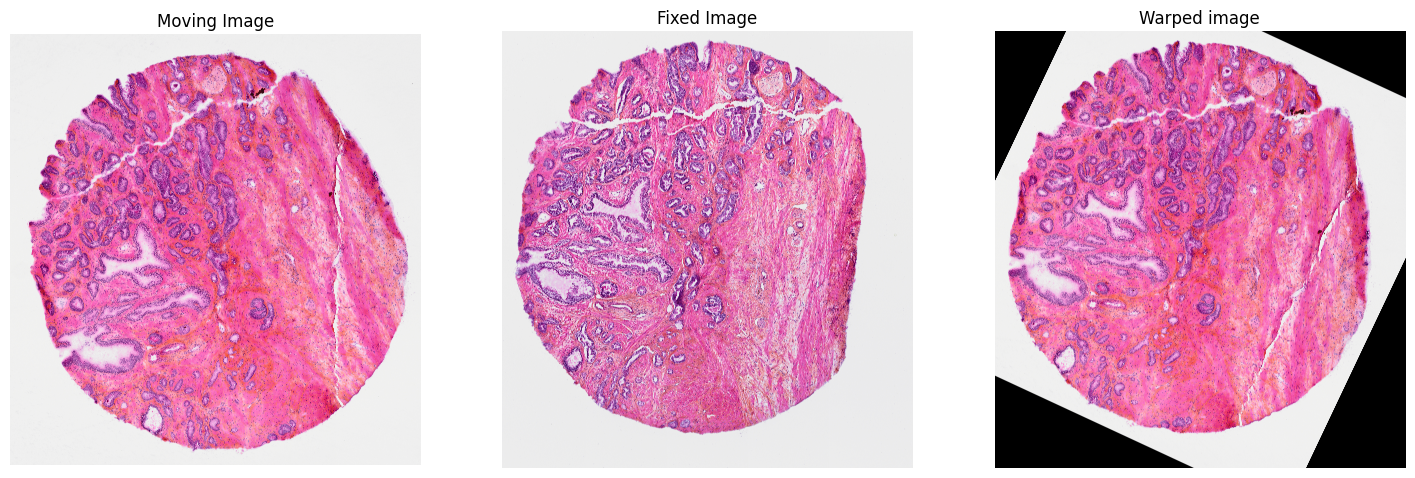

In [10]:
# First we do a quick affine registration
# We can do affine and tiling in one go. This is just for demonstration purposes.
options = RegistrationOptions()
options.do_nonrigid_registration = False
options.affine_registration_options.n_threads = 8

# For large images we recommend to use downscaling.
# options.pre_sampling_factor = 0.25

registration_result = registerer.register(moving_img=moving_image.data,
                                          fixed_img=fixed_image.data,
                                          options=options
                                          )

affine_trans_image = registerer.transform_image(moving_image.data, registration_result.registration.forward_transform)

fig, axs = plt.subplots(1, 3, figsize=(18 ,6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(moving_image.data)
axs[0].set_title('Moving Image')
axs[1].imshow(fixed_image.data)
axs[1].set_title('Fixed Image')
axs[2].imshow(affine_trans_image)
axs[2].set_title('Warped image')

We are now performing the tiling nonrigid registration. We will set the tile_size to 8126 x 8126 as an example. During the registration tiles will still be downscaled to 1024 x 1024, as this seemed to work best for this type of data. Generally the downsampled images should not exceed ~3500 pixel resolution on any axes.

The tile size can also be set to 1024 x 1024, which should work as well, but will results in a longer runtime as the amount of tiles increases quadratically.

In [11]:
# We can now do a tiling nonrigid registration.

options = RegistrationOptions()
options.do_affine_registration = False

# We enable tiling by setting the flag
options.tiling_options.enable_tiling = True

# We choose a size for tiles.
options.tiling_options.tile_size = (8126, 8126)

# To ensure that stitched transformations are smooth, we set some minimum overlap.
options.tiling_options.min_overlap = 0.5

# We can set n_procs to a number to perform the registration concurrently.
options.tiling_options.n_procs = 6



In [12]:
# The image here is a larger and will take longer to be processed.

tiling_reg_result = registerer.register(affine_trans_image, fixed_image.data, options=options, verbose=False)

In [26]:
tiling_warped_image = registerer.transform_image(affine_trans_image, tiling_reg_result.registration.forward_transform)

Text(0.5, 1.0, 'Nonrigid warped image.')

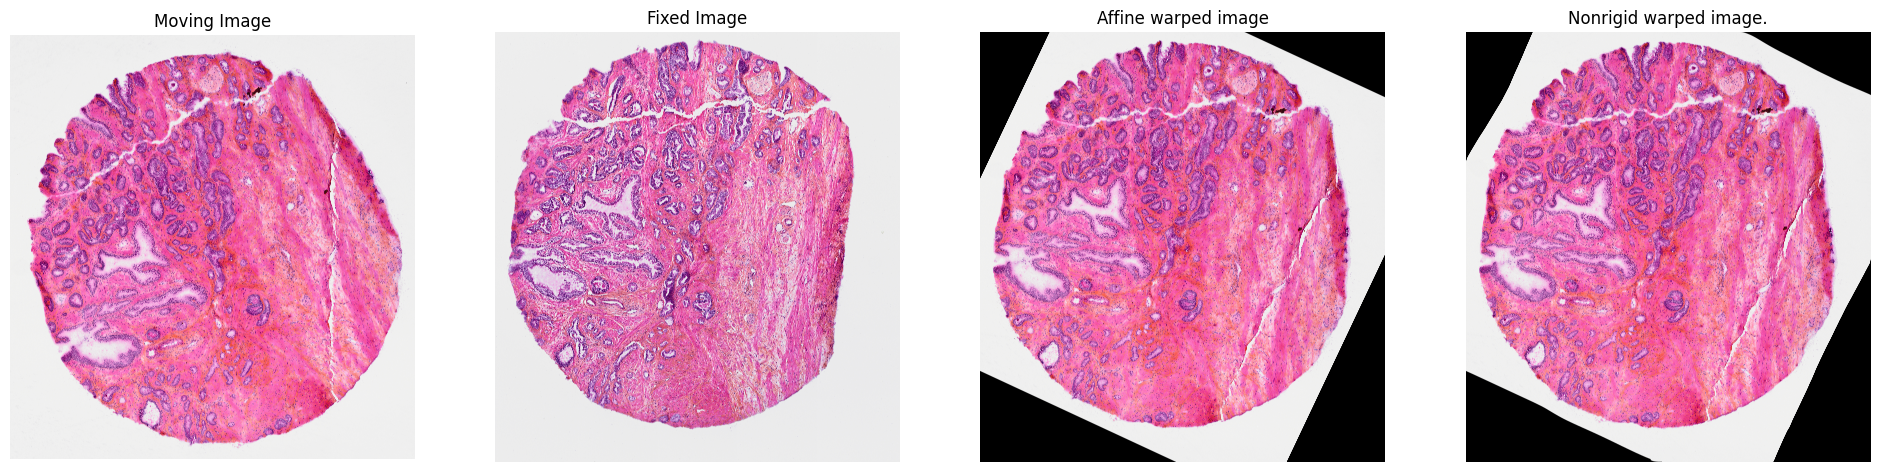

In [27]:
fig, axs = plt.subplots(1, 4, figsize=(24 ,6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(moving_image.data)
axs[0].set_title('Moving Image')
axs[1].imshow(fixed_image.data)
axs[1].set_title('Fixed Image')
axs[2].imshow(affine_trans_image)
axs[2].set_title('Affine warped image')
axs[3].imshow(tiling_warped_image)
axs[3].set_title('Nonrigid warped image.')

### Segmentation

By default, GreedyFHist uses a segmentation method that predicts tissue using the YOLO8 model. In some cases, a different segmentation might be more suitable. For this reason we have implemented two additional segmentation functions that we will shortly hightlight: One that uses local entropy to detect tissue and one based on luminosity of images.

In [28]:
from greedyfhist.segmentation import load_segmentation_function

In [29]:
# Load segmentation functions.

# Yolo segmentation function
yolo_seg_fun = load_segmentation_function('yolo-seg')
# Entropy based segmentation function
ent_seg_fun = load_segmentation_function('entropy-based-seg')
# Luminosity and area based segmentation function
lum_seg_fun = load_segmentation_function('lum-area-seg')

In [30]:
moving_img = moving_image.data

yolo_mask = yolo_seg_fun(moving_img)
ent_mask = ent_seg_fun(moving_img)
lum_mask = lum_seg_fun(moving_img)

Text(0.5, 1.0, 'Masked with luminosity and area based segmentation.')

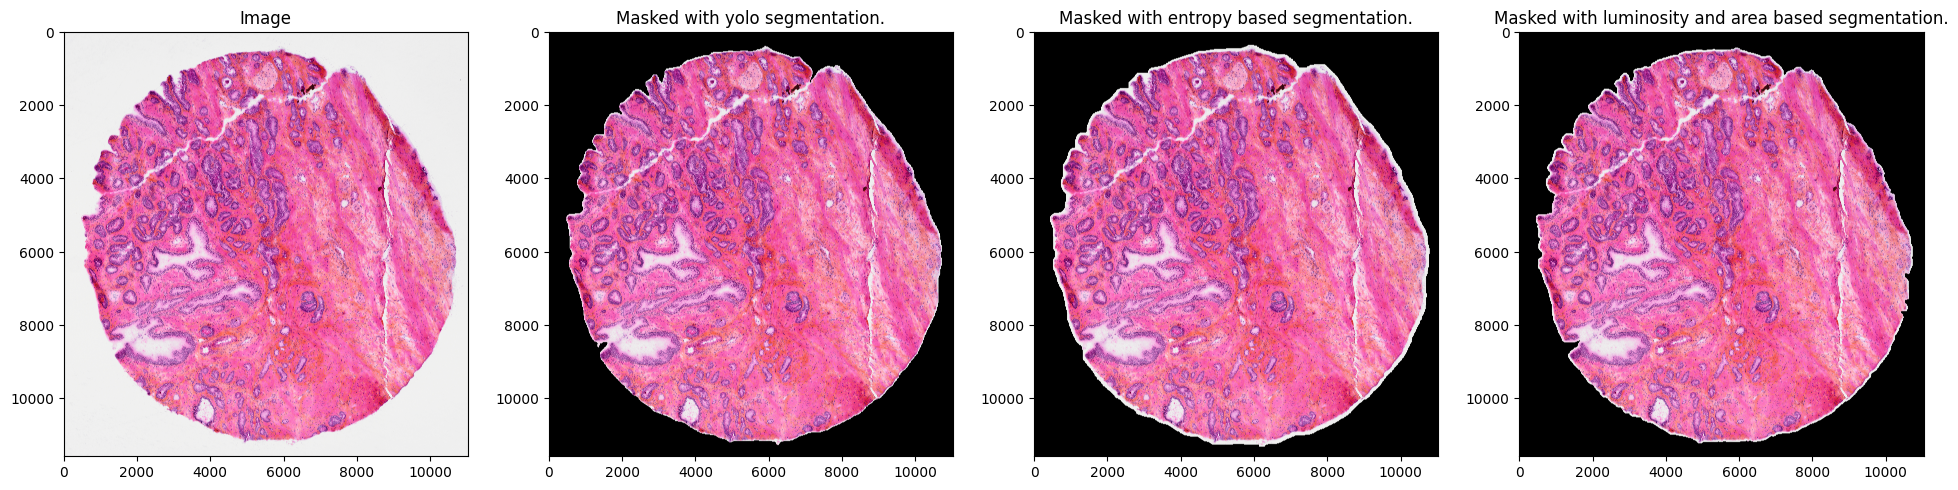

In [31]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
axs[0].imshow(moving_img)
axs[0].set_title('Image')
axs[1].imshow(moving_img * np.expand_dims(yolo_mask, -1))
axs[1].set_title('Masked with yolo segmentation.')
axs[2].imshow(moving_img * np.expand_dims(ent_mask, -1))
axs[2].set_title('Masked with entropy based segmentation.')
axs[3].imshow(moving_img * np.expand_dims(lum_mask, -1))
axs[3].set_title('Masked with luminosity and area based segmentation.')